<h1 style="text-align: center;" markdown="1">Machine Learning Algorithms for Poverty Prediction</h1> 
<h2 style="text-align: center;" markdown="2">A project of the World Bank's Knowledge for Change Program</h2>
<h3 style="text-align: center;" markdown="3">(KCP, Grant TF0A4534)</h3>


> *This notebook is part of a series that has been developed as an empirical comparative assessment of machine learning classification algorithms applied to poverty prediction. The objectives of this project are to explore how well machine learning algorithms perform when given the task to identify the poor in a given population, and to provide a resource of machine learning techniques for researchers, data scientists, and statisticians in developing countries.*

<h1 style="text-align: center;" markdown="3">Algorithm 6 - Decision Tree Classifier</h1> 
<h2 style="text-align: center;" markdown="3">Part 2: Indonesia Poverty Prediction</h2> 

# Table of Contents
[Introduction](#introduction)  
[Decision Tree Classifier with Simple Features](#dt-simple)  
[Decision Tree Classifier with Full Features](#dt-full)  
&nbsp;&nbsp;&nbsp;[Undersampling](#undersampling)  
&nbsp;&nbsp;&nbsp;[Oversampling](#oversampling)  
&nbsp;&nbsp;&nbsp;[Tune Parameters and Cross-Validate](#tune-cv)   
[AdaBoost](#ada-boost)  
[Feature Selection](#feature-selection)  
[Summary](#summary)

# Introduction <a class="anchor" id="introduction"></a>

We will now apply the Decision Tree classifier to the Indonesia dataset and explore how having an unbalanced dataset impacts the classifier performance. 

As always, we start with loading our standard libraries and the Indonesia data

In [1]:
%matplotlib inline

import os
import sys
import json

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set()

# Add our local functions to the path
sys.path.append(os.path.join(os.pardir, 'src'))
from models import evaluation
from data.load_data import (get_country_filepaths, 
                            split_features_labels_weights, 
                            load_data)
from features.process_features import get_vif, standardize
from features.process_features import IDN_BASIC_FEATURES

ALGORITHM_NAME = 'dt'
COUNTRY = 'idn'
TRAIN_PATH, TEST_PATH, QUESTIONS_PATH = get_country_filepaths(COUNTRY)

# load text of survey questions for reference
with open(QUESTIONS_PATH, 'r') as fp:
    questions = json.load(fp)

/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# load training data
X_train, y_train, w_train = split_features_labels_weights(TRAIN_PATH)

# summarize loaded data
print('Data has {:,} rows and {:,} columns' \
        .format(*X_train.shape))

print('Percent poor: {:0.1%} \tPercent non-poor: {:0.1%}' \
        .format(*y_train.poor.value_counts(normalize=True, ascending=True)))

# print first 5 rows of data
X_train.head()

Data has 53,132 rows and 453 columns
Percent poor: 9.0% 	Percent non-poor: 91.0%


,geo_district,geo_subdistrict,geo_village,der_hhsize,hld_nbcell,der_nchild10under,der_nmalesover10,der_nfemalesover10,der_nliterate,der_nemployedpast3mo,...,cons_333__Yes,cons_334__Yes,cons_335__Yes,cons_336__Yes,cons_338__Yes,cons_339__Yes,cons_340__Yes,cons_341__Yes,cons_342__Yes,cons_343__Yes
hid,,,,,,,,,,,,,,,,,,,,,
8271030150650101,8271,30,15,5,1,1,2,2,5,1,...,1,0,0,0,0,0,0,0,0,0
7316020200500509,7316,20,13,5,1,4,0,1,2,0,...,1,0,0,0,0,0,0,0,0,0
5108050200860107,5108,50,4,3,0,0,0,3,0,2,...,0,0,0,0,0,0,0,0,1,0
3301190201430210,3301,190,15,2,1,0,1,1,2,2,...,0,0,0,0,0,0,0,0,0,0
6304140250030508,6304,140,4,6,4,1,3,2,5,3,...,0,0,0,0,0,0,0,0,0,0


# Decision Tree with simple features <a class="anchor" id="dt-simple"></a>

We'll start with the simple set of features stored in `IDN_BASIC_FEATURES` in the `process_features` module.

In [3]:
# Select the basic features we've used previously
selected_columns = IDN_BASIC_FEATURES
print("X shape with selected columns:", X_train[selected_columns].shape)

X shape with selected columns: (53132, 9)


In [4]:
# Create DataFrame of feature importances
def get_feat_imp_df(feat_imps, index=None, sort=True):
    feat_imps = pd.DataFrame(feat_imps, columns=['importance'])
    if index is not None:
        feat_imps.index = index
    if sort:
        feat_imps = feat_imps.sort_values('importance', ascending=False)
    return feat_imps

CPU times: user 101 ms, sys: 0 ns, total: 101 ms
Wall time: 102 ms
CPU times: user 16.8 ms, sys: 9 µs, total: 16.9 ms
Wall time: 16.9 ms
In-sample score: 92.97%


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


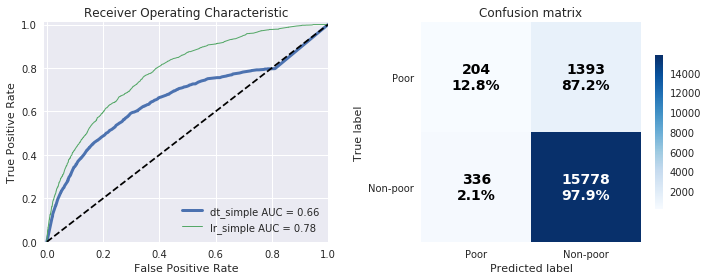

,dt_simple,lr_simple
accuracy,0.902377,0.91158
recall,0.12774,0.0851597
precision,0.377778,0.564315
f1,0.190922,0.147987
cross_entropy,1.32187,0.256817
roc_auc,0.657529,0.781848
cohen_kappa,0.152292,0.127352


Actual poverty rate: 11.38% 
Predicted poverty rate: 3.20% 


In [5]:
from sklearn.tree import DecisionTreeClassifier

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH, 
                                      selected_columns=selected_columns)

# Fit the model
model = DecisionTreeClassifier()
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))
feat_imps = get_feat_imp_df(model.feature_importances_, index=X_train.columns)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH, 
                                   selected_columns=selected_columns)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, 
                                    compare_models=['lr_simple'],
                                    store_model=True,
                                    model_name='simple', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=feat_imps)

In [6]:
feat_imps

,importance
der_nliterate,0.189577
der_nemployedpast3mo,0.187343
der_nchild10under,0.164086
der_nmalesover10,0.141734
der_nfemalesover10,0.108634
hld_toilet__None,0.090307
hld_lighting__PLN electricity,0.057837
cons_029__Yes,0.044822
cons_054__Yes,0.015662


# Decision Tree with all features <a class="anchor" id="all-feats"></a>

Now let's apply the Decision Tree classifier to the dataset with all features. 

CPU times: user 5.74 s, sys: 115 ms, total: 5.86 s
Wall time: 11.6 s
CPU times: user 202 ms, sys: 61.7 ms, total: 263 ms
Wall time: 568 ms
In-sample score: 100.00%


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


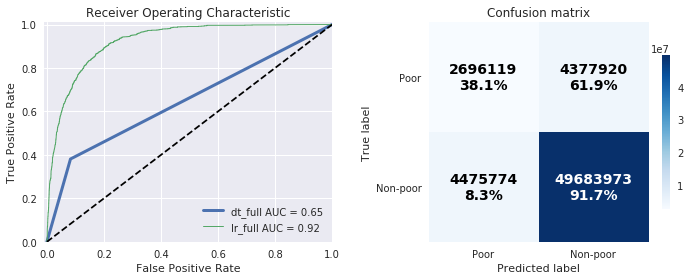

,dt_full,lr_full
accuracy,0.855412,0.910251
recall,0.381129,0.456232
precision,0.375928,0.661838
f1,0.378511,0.540131
cross_entropy,4.99396,0.212947
roc_auc,0.649244,0.923198
cohen_kappa,0.293831,0.483497


Actual poverty rate: 11.38% 
Predicted poverty rate: 11.42% 


In [7]:
# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)

# Fit the model
model = DecisionTreeClassifier()
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train, w_train)
print("In-sample score: {:0.2%}".format(score))
feat_imps = get_feat_imp_df(model.feature_importances_, index=X_train.columns)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models='lr_full',
                                    store_model=True,
                                    model_name='full', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=feat_imps)

As with the Malawi dataset, the decision tree classifier tends to overfit the training data when we make all the features available.

## Class Weighting
The decision tree classifier includes the option to balance the classes with `class_weight='balanced'`, so we'll first try this before applying a sampling method. We'll also pick a few parameters to reduce overfitting.

CPU times: user 5.33 s, sys: 155 ms, total: 5.49 s
Wall time: 11.9 s
CPU times: user 82 ms, sys: 160 ms, total: 242 ms
Wall time: 1.54 s
In-sample score: 86.21%


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


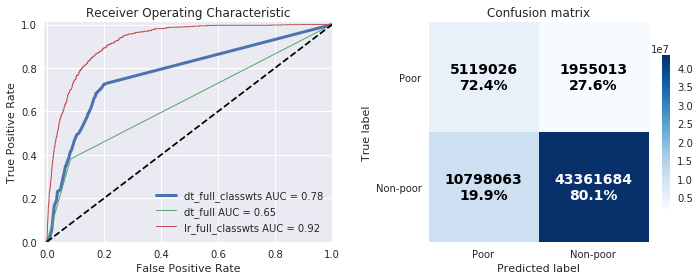

,dt_full_classwts,dt_full,lr_full_classwts
accuracy,0.791731,0.855412,0.830513
recall,0.723636,0.381129,0.866754
precision,0.321606,0.375928,0.39387
f1,0.445304,0.378511,0.541618
cross_entropy,1.50218,4.99396,0.384733
roc_auc,0.776591,0.649244,0.923196
cohen_kappa,0.323774,0.293831,0.428159


Actual poverty rate: 11.38% 
Predicted poverty rate: 25.30% 


In [8]:
# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)

# Fit the model
model = DecisionTreeClassifier(max_depth=15, 
                               min_samples_leaf=5, 
                               min_samples_split=5, 
                               class_weight='balanced')
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train, w_train)
print("In-sample score: {:0.2%}".format(score))
feat_imps = get_feat_imp_df(model.feature_importances_, index=X_train.columns)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['dt_full', 
                                                    'lr_full_classwts'],
                                    store_model=True,
                                    model_name='full_classwts', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=feat_imps)

## Undersampling <a class="anchor" id="undersampling">
Now we'll apply undersampling and see how the performance is affected.

X shape after undersampling:  (9584, 453)
CPU times: user 939 ms, sys: 13.7 ms, total: 953 ms
Wall time: 3.06 s
CPU times: user 14.6 ms, sys: 0 ns, total: 14.6 ms
Wall time: 38.6 ms
In-sample score: 90.94%
CPU times: user 48.3 ms, sys: 23.5 ms, total: 71.7 ms
Wall time: 196 ms
CPU times: user 21.4 ms, sys: 38.4 ms, total: 59.9 ms
Wall time: 141 ms


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


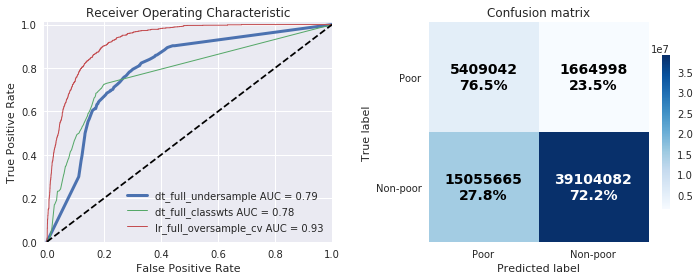

,dt_full_undersample,dt_full_classwts,lr_full_oversample_cv
accuracy,0.726937,0.791731,0.851611
recall,0.764633,0.723636,0.838116
precision,0.264311,0.321606,0.427456
f1,0.392831,0.445304,0.566159
cross_entropy,4.1474,1.50218,0.348544
roc_auc,0.789919,0.776591,0.925356
cohen_kappa,0.257572,0.323774,0.471316


Actual poverty rate: 11.38% 
Predicted poverty rate: 33.24% 


In [9]:
from imblearn.under_sampling import RandomUnderSampler

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)
cols = X_train.columns

# Apply random undersampling
X_train, y_train = RandomUnderSampler().fit_sample(X_train, y_train)
X_train = pd.DataFrame(X_train, columns=cols)
print("X shape after undersampling: ", X_train.shape)

# Fit the model
model = DecisionTreeClassifier(max_depth=15, 
                               min_samples_leaf=5, 
                               min_samples_split=5)
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))
feat_imps = get_feat_imp_df(model.feature_importances_, index=X_train.columns)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
%time y_pred = model.predict(X_test)
%time y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['dt_full_classwts', 
                                                    'lr_full_oversample_cv'],
                                    store_model=True,
                                    model_name='full_undersample', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=feat_imps)

## Oversampling <a class="anchor" id="oversampling">

X shape after oversampling:  (96680, 453)
CPU times: user 24.2 s, sys: 160 ms, total: 24.3 s
Wall time: 54.2 s
CPU times: user 141 ms, sys: 103 ms, total: 245 ms
Wall time: 292 ms
In-sample score: 95.82%
CPU times: user 69.3 ms, sys: 45.5 ms, total: 115 ms
Wall time: 224 ms
CPU times: user 46 ms, sys: 30.7 ms, total: 76.7 ms
Wall time: 137 ms


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


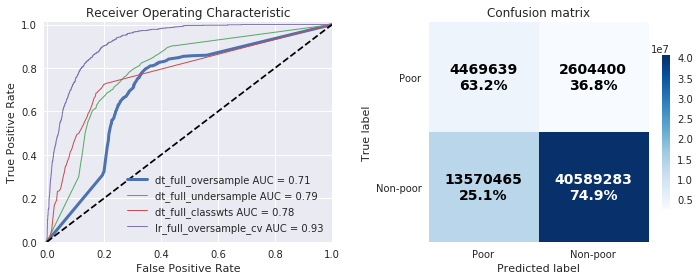

,dt_full_oversample,dt_full_undersample,dt_full_classwts,lr_full_oversample_cv
accuracy,0.735851,0.726937,0.791731,0.851611
recall,0.631837,0.764633,0.723636,0.838116
precision,0.247761,0.264311,0.321606,0.427456
f1,0.355946,0.392831,0.445304,0.566159
cross_entropy,6.75102,4.1474,1.50218,0.348544
roc_auc,0.714292,0.789919,0.776591,0.925356
cohen_kappa,0.220204,0.257572,0.323774,0.471316


Actual poverty rate: 11.38% 
Predicted poverty rate: 15.84% 


In [10]:
from imblearn.over_sampling import SMOTE

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)
cols = X_train.columns

# Apply oversampling with SMOTE
X_train, y_train = SMOTE().fit_sample(X_train, y_train)
X_train = pd.DataFrame(X_train, columns=cols)
print("X shape after oversampling: ", X_train.shape)

# Fit the model
model = DecisionTreeClassifier(max_depth=15, 
                               min_samples_leaf=5, 
                               min_samples_split=5)
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))
feat_imps = get_feat_imp_df(model.feature_importances_, index=X_train.columns)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
%time y_pred = model.predict(X_test)
%time y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['dt_full_undersample', 
                                                    'dt_full_classwts', 
                                                    'lr_full_oversample_cv'],
                                    store_model=True,
                                    model_name='full_oversample', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=feat_imps)

## Tune parameters and cross-validate <a class="anchor" id="tune-cv"></a>


X shape after undersampling:  (9584, 453)
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   24.2s finished


CPU times: user 7.61 s, sys: 574 ms, total: 8.19 s
Wall time: 27.3 s
CPU times: user 13.3 ms, sys: 575 µs, total: 13.8 ms
Wall time: 51.5 ms
In-sample score: 80.40%
Best model parameters: {'max_depth': 6, 'min_samples_leaf': 21, 'min_samples_split': 2}


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


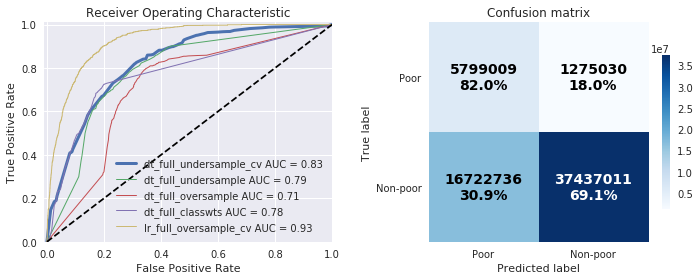

,dt_full_undersample_cv,dt_full_undersample,dt_full_oversample,dt_full_classwts,lr_full_oversample_cv
accuracy,0.706081,0.726937,0.735851,0.791731,0.851611
recall,0.819759,0.764633,0.631837,0.723636,0.838116
precision,0.257485,0.264311,0.247761,0.321606,0.427456
f1,0.391881,0.392831,0.355946,0.445304,0.566159
cross_entropy,0.566227,4.1474,6.75102,1.50218,0.348544
roc_auc,0.825405,0.789919,0.714292,0.776591,0.925356
cohen_kappa,0.248044,0.257572,0.220204,0.323774,0.471316


Actual poverty rate: 11.38% 
Predicted poverty rate: 36.53% 


In [11]:
from sklearn.model_selection import GridSearchCV

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)
cols = X_train.columns

# Apply random undersampling
X_train, y_train = RandomUnderSampler().fit_sample(X_train, y_train)
X_train = pd.DataFrame(X_train, columns=cols)
print("X shape after undersampling: ", X_train.shape)

# build the model
estimator = DecisionTreeClassifier()
parameters = {'max_depth': np.arange(1,16,5), 
              'min_samples_split': np.arange(2,21,10),
              'min_samples_leaf': np.arange(1,46,20)
             }
model = GridSearchCV(estimator, parameters, verbose=1, cv=5, n_jobs=-1)
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))
print("Best model parameters:", model.best_params_)
feat_imps = get_feat_imp_df(model.best_estimator_.feature_importances_, index=X_train.columns)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['dt_full_undersample', 
                                                    'dt_full_oversample', 
                                                    'dt_full_classwts', 
                                                    'lr_full_oversample_cv'],
                                    store_model=True,
                                    model_name='full_undersample_cv', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=feat_imps)
best_model = model.best_estimator_

Cross validation for this model has only a minor impact on performance. As with Logistic Regression, we tend to get better recall using undersamping, but better overall performance using oversampling. 

In [12]:
feat_imps.head(20)

,importance
hld_cooking__Firewood,0.353691
der_hhsize,0.256010
cons_292__Yes,0.107280
hld_refrigerator__Yes,0.077474
geo_district,0.037909
hld_nbcell,0.024673
cons_304__Yes,0.017982
geo_province__East Java,0.014885
cons_266__Yes,0.014662
cons_246__Yes,0.012337


# AdaBoost Decision Tree Classifier <a class="anchor" id="ada-boost"></a>

X shape after undersampling:  (9584, 453)
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] learning_rate=0.01, n_estimators=50 .............................
[CV] learning_rate=0.01, n_estimators=50 .............................
[CV] learning_rate=0.01, n_estimators=50 .............................
[CV] learning_rate=0.01, n_estimators=100 ............................
[CV] learning_rate=0.01, n_estimators=100 ............................
[CV] learning_rate=0.01, n_estimators=100 ............................
[CV] learning_rate=0.1, n_estimators=50 ..............................
[CV] learning_rate=0.1, n_estimators=50 ..............................
[CV] learning_rate=0.1, n_estimators=50 ..............................
[CV] learning_rate=0.1, n_estimators=100 .............................
[CV] learning_rate=0.1, n_estimators=100 .............................
[CV] learning_rate=0.1, n_estimators=100 .............................
[CV]  learning_rate=0.01, n_estimators=50, sco

[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:  1.0min remaining:  2.1min


[CV]  learning_rate=0.1, n_estimators=50, score=0.8331246086412023, total= 1.1min
[CV]  learning_rate=0.1, n_estimators=50, score=0.8321853475266124, total= 1.1min
[CV]  learning_rate=0.01, n_estimators=100, score=0.8187226048841578, total= 1.8min
[CV]  learning_rate=0.01, n_estimators=100, score=0.8265497808390733, total= 1.8min
[CV]  learning_rate=0.1, n_estimators=100, score=0.8294743429286608, total= 1.8min


[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:  1.8min remaining:   36.2s


[CV]  learning_rate=0.01, n_estimators=100, score=0.8178973717146433, total= 1.8min
[CV]  learning_rate=0.1, n_estimators=100, score=0.8368816530995616, total= 1.8min
[CV]  learning_rate=0.1, n_estimators=100, score=0.8418910457107076, total= 2.0min


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  2.0min finished


CPU times: user 1min 9s, sys: 905 ms, total: 1min 9s
Wall time: 4min 23s
CPU times: user 741 ms, sys: 9.14 ms, total: 750 ms
Wall time: 1.46 s
In-sample score: 97.63%
Best model parameters: {'learning_rate': 0.1, 'n_estimators': 100}


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


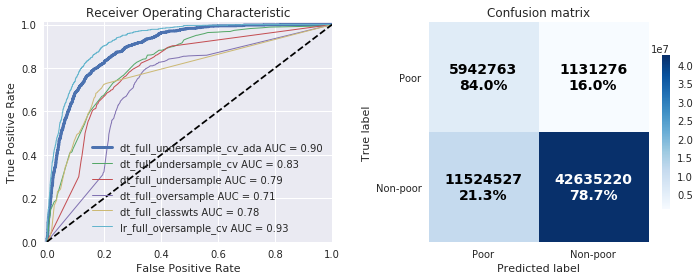

,dt_full_undersample_cv_ada,dt_full_undersample_cv,dt_full_undersample,dt_full_oversample,dt_full_classwts,lr_full_oversample_cv
accuracy,0.79332,0.706081,0.726937,0.735851,0.791731,0.851611
recall,0.840081,0.819759,0.764633,0.631837,0.723636,0.838116
precision,0.340222,0.257485,0.264311,0.247761,0.321606,0.427456
f1,0.484307,0.391881,0.392831,0.355946,0.445304,0.566159
cross_entropy,0.471503,0.566227,4.1474,6.75102,1.50218,0.348544
roc_auc,0.897173,0.825405,0.789919,0.714292,0.776591,0.925356
cohen_kappa,0.371236,0.248044,0.257572,0.220204,0.323774,0.471316


Actual poverty rate: 11.38% 
Predicted poverty rate: 28.45% 


In [13]:
from sklearn.ensemble import AdaBoostClassifier

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)
cols = X_train.columns

# Apply random undersampling
X_train, y_train = RandomUnderSampler().fit_sample(X_train, y_train)
X_train = pd.DataFrame(X_train, columns=cols)
print("X shape after undersampling: ", X_train.shape)

# build the model
estimator = AdaBoostClassifier(best_model)

parameters = {'n_estimators': [50, 100], 
              'learning_rate': [0.01, 0.1]
             }
model = GridSearchCV(estimator, parameters, verbose=3, cv=3, n_jobs=-1)
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))
print("Best model parameters:", model.best_params_)
feat_imps = get_feat_imp_df(model.best_estimator_.feature_importances_, index=X_train.columns)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['dt_full_undersample_cv', 
                                                    'dt_full_undersample', 
                                                    'dt_full_oversample', 
                                                    'dt_full_classwts', 
                                                    'lr_full_oversample_cv'],
                                    store_model=True,
                                    model_name='full_undersample_cv_ada', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=feat_imps)
best_model = model.best_estimator_

In [14]:
feat_imps.head(20)

,importance
geo_district,0.083815
der_hhsize,0.079498
geo_village,0.024440
geo_subdistrict,0.024015
der_nchild10under,0.018701
cons_292__Yes,0.015173
cons_199__Yes,0.013757
hld_cooking__Firewood,0.013615
der_nliterate,0.012973
hld_refrigerator__Yes,0.012804


# Feature selection <a class="anchor" id="feature-selection"></a>

X shape after feature selection:  (53132, 175)
X shape after undersampling:  (9584, 175)
CPU times: user 25.5 s, sys: 49.9 ms, total: 25.6 s
Wall time: 44.4 s
CPU times: user 482 ms, sys: 8 ms, total: 490 ms
Wall time: 581 ms
In-sample score: 97.89%


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


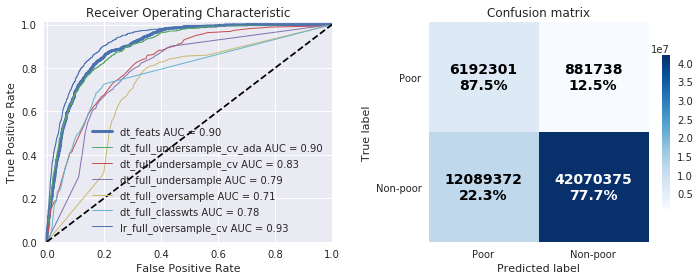

,dt_feats,dt_full_undersample_cv_ada,dt_full_undersample_cv,dt_full_undersample,dt_full_oversample,dt_full_classwts,lr_full_oversample_cv
accuracy,0.788171,0.79332,0.706081,0.726937,0.735851,0.791731,0.851611
recall,0.875356,0.840081,0.819759,0.764633,0.631837,0.723636,0.838116
precision,0.338716,0.340222,0.257485,0.264311,0.247761,0.321606,0.427456
f1,0.488434,0.484307,0.391881,0.392831,0.355946,0.445304,0.566159
cross_entropy,0.474249,0.471503,0.566227,4.1474,6.75102,1.50218,0.348544
roc_auc,0.902264,0.897173,0.825405,0.789919,0.714292,0.776591,0.925356
cohen_kappa,0.366234,0.371236,0.248044,0.257572,0.220204,0.323774,0.471316


Actual poverty rate: 11.38% 
Predicted poverty rate: 29.15% 


In [15]:
feats = feat_imps[feat_imps.cumsum() <= 0.90].dropna().index.values

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH, selected_columns=feats)
cols = X_train.columns
print("X shape after feature selection: ", X_train.shape)

# Apply random undersampling
X_train, y_train = RandomUnderSampler().fit_sample(X_train, y_train)
X_train = pd.DataFrame(X_train, columns=cols)
print("X shape after undersampling: ", X_train.shape)

# Fit the model
model = best_model
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))
feat_imps = get_feat_imp_df(model.feature_importances_, index=X_train.columns)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH, selected_columns=feats)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['dt_full_undersample_cv_ada', 
                                                    'dt_full_undersample_cv', 
                                                    'dt_full_undersample', 
                                                    'dt_full_oversample', 
                                                    'dt_full_classwts', 
                                                    'lr_full_oversample_cv'],
                                    store_model=True,
                                    model_name='feats', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model,
                                    features=feat_imps)

In [16]:
cons_feats = [x.split('__')[0] for x in feats if x[0:5] == 'cons_']
print("{} consumables features selected:".format(len(cons_feats)))
for x in cons_feats:
    print(questions[x])

120 consumables features selected:
Gasoline/pertamax
A plate of rice accompanied by a mixture of dishes
Clove filter cigarettes
Transport expenses
Instant noodle
Pork
Clove non filter cigarettes
Powdered/bean coffee
Other drinks (coffee, milk, etc) 
Broiler egg
Others (batteries, storage batteries, matches,..)
Ready-made clothes for women
Noodle (with meatball/boiled/fried)
Lubricant
Clothes maintenance material
Tea
Cane sugar
Medical Doctor private/public hospital
Other bread
Swamp cabbage
Chillies
Cigarettes
Expenses on gasoline
Motor vehicle's service and repair
Eastern tuna/skipjack tuna
Orange
Broiler meat
Fresh corn with skin
Mobile phone bill
Fish paste
Local chicken meat
Kitchen utensils
Tamarind
Lanzon
Home appliances (iron, broom, scissors, knives, machetes, hoes, saws, vacuum cle
Fried food
'Raja' 
Headgear for men, women, and children (hat, cap, scarf, etc..)
Textbooks, photocopies of learning materials
Rice steamed in a banana leaf or coconut leaf
String bean
School fee
Ot

# Decision Trees Indonesia Summary <a class="anchor" id="summary"></a>



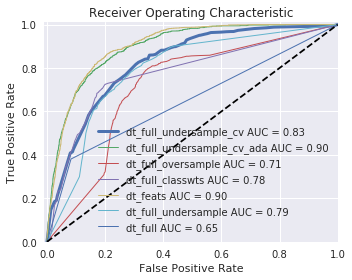

,accuracy,recall,precision,f1,cross_entropy,roc_auc,cohen_kappa,pov_rate_error
dt_full_undersample_cv,0.706081,0.819759,0.257485,0.391881,0.566227,0.825405,0.248044,0.25148
dt_full_undersample_cv_ada,0.79332,0.840081,0.340222,0.484307,0.471503,0.897173,0.371236,0.170676
dt_full_oversample,0.735851,0.631837,0.247761,0.355946,6.75102,0.714292,0.220204,0.0446508
dt_full_classwts,0.791731,0.723636,0.321606,0.445304,1.50218,0.776591,0.323774,0.139192
dt_feats,0.788171,0.875356,0.338716,0.488434,0.474249,0.902264,0.366234,0.177672
dt_full_undersample,0.726937,0.764633,0.264311,0.392831,4.1474,0.789919,0.257572,0.218636
dt_full,0.855412,0.381129,0.375928,0.378511,4.99396,0.649244,0.293831,0.000402674


In [17]:
evaluation.compare_algorithm_models(ALGORITHM_NAME, COUNTRY)